# Pipeline de Modelado - Predicción de Precios de Alquiler en AMBA

## Integrantes del Equipo
- Ignacio Bruzone
- Felix Lopez Menardi
- Christian Ijjas

## Fecha
2025

---

## Tabla de Contenidos
1. [Carga y Preparación de Datos](#1-carga-y-preparación-de-datos)
2. [Ingeniería de Features](#2-ingeniería-de-features)
3. [División de Datos](#3-división-de-datos)
4. [Selección y Entrenamiento de Modelos](#4-selección-y-entrenamiento-de-modelos)
5. [Evaluación de Modelos](#5-evaluación-de-modelos)
6. [Optimización de Hiperparámetros](#6-optimización-de-hiperparámetros)
7. [Evaluación Final con Test Set](#7-evaluación-final-con-test-set)
8. [Guardado del Modelo](#8-guardado-del-modelo)

---


In [17]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import joblib
import warnings
import json
from datetime import datetime
import os

warnings.filterwarnings('ignore')

# Configuración
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Semilla para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✓ Librerías importadas correctamente")


✓ Librerías importadas correctamente


## 1. Carga y Preparación de Datos


In [18]:
# Cargar datos limpios
df = pd.read_csv('output/alquiler_AMBA_clean.csv')

print(f"Dataset cargado: {df.shape[0]:,} registros, {df.shape[1]} columnas")
print(f"\nPrimeras filas:")
df.head()


Dataset cargado: 95,785 registros, 34 columnas

Primeras filas:


,id_grid,MesListing,STotalM2,Dormitorios,Banos,Ambientes,Amoblado,Antiguedad,AccesoInternet,Gimnasio,Laundry,Calefaccion,SalonDeUsosMul,AireAC,Jacuzzi,Ascensor,Seguridad,Pileta,Cocheras,AreaParrillas,ITE_ADD_CITY_NAME,ITE_ADD_STATE_NAME,ITE_ADD_NEIGHBORHOOD_NAME,ITE_TIPO_PROD,LONGITUDE,LATITUDE,precio_pesos_constantes,year,precio_por_m2,densidad_ambientes,total_amenities,tiene_cochera,mes,estacion
0,96453,2022-12-01,35.0,1,2,2,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,Escobar,Bs.As. G.B.A. Norte,Ingeniero Maschwitz,U,-58.749382,-34.393033,3924.012333,2022,112.114638,0.057143,0.0,0,12,verano
1,50114,2022-12-01,25.0,1,1,1,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,Morón,Bs.As. G.B.A. Oeste,Morón,U,-58.645631,-34.648746,6278.419732,2022,251.136789,0.040000,0.0,1,12,verano
2,59092,2022-12-01,55.0,1,1,2,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,Capital Federal,Capital Federal,Villa Crespo,U,-58.437530,-34.602686,9529.744236,2022,173.268077,0.036364,0.0,0,12,verano
3,48597,2022-12-01,64.0,1,1,2,1.0,10.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1,0.0,Capital Federal,Capital Federal,Puerto Madero,U,-58.366516,-34.661212,43569.990649,2022,680.781104,0.031250,7.0,1,12,verano
4,95840,2022-12-01,184.0,2,2,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0.0,Tigre,Bs.As. G.B.A. Norte,Nordelta Marinas del Canal,N,-58.651584,-34.397999,54462.488311,2022,295.991784,0.016304,3.0,1,12,verano


In [19]:
# SPLIT ESTRATIFICADO: Train (70%), Validation (20%), Test (10%)
# Crear bins de precio para estratificación
print("=" * 100)
print("DIVISIÓN ESTRATIFICADA DEL DATASET")
print("=" * 100)

# Crear bins basados en cuartiles del precio para estratificación
df['price_bin'] = pd.qcut(df['precio_pesos_constantes'], q=10, labels=False, duplicates='drop')

# Primero separar test set (10%)
df_train_val, df_test = train_test_split(
    df, 
    test_size=0.10, 
    random_state=RANDOM_STATE,
    stratify=df['price_bin'],
    shuffle=True
)

# Luego separar train (70% del total) y validation (20% del total)
# Del 90% restante: 70/90 = 0.778 será train, 20/90 = 0.222 será validation
df_train, df_val = train_test_split(
    df_train_val,
    test_size=0.222,  # 20% del total
    random_state=RANDOM_STATE,
    stratify=df_train_val['price_bin'],
    shuffle=True
)

# Eliminar la columna auxiliar de bins
df_train = df_train.drop(columns=['price_bin'])
df_val = df_val.drop(columns=['price_bin'])
df_test = df_test.drop(columns=['price_bin'])
df = df.drop(columns=['price_bin'])

print(f"\n✓ División completada:")
print(f"  Train set:      {len(df_train):,} registros ({len(df_train)/len(df)*100:.1f}%)")
print(f"  Validation set: {len(df_val):,} registros ({len(df_val)/len(df)*100:.1f}%)")
print(f"  Test set:       {len(df_test):,} registros ({len(df_test)/len(df)*100:.1f}%)")

print(f"\n✓ Distribución de precios:")
print(f"  Train -      Media: ${df_train['precio_pesos_constantes'].mean():,.2f}, Mediana: ${df_train['precio_pesos_constantes'].median():,.2f}")
print(f"  Validation - Media: ${df_val['precio_pesos_constantes'].mean():,.2f}, Mediana: ${df_val['precio_pesos_constantes'].median():,.2f}")
print(f"  Test -       Media: ${df_test['precio_pesos_constantes'].mean():,.2f}, Mediana: ${df_test['precio_pesos_constantes'].median():,.2f}")

# Guardar datasets
df_train.to_csv('output/train_set.csv', index=False)
df_val.to_csv('output/validation_set.csv', index=False)
df_test.to_csv('output/test_set.csv', index=False)

print(f"\n✓ Datasets guardados:")
print(f"  output/train_set.csv")
print(f"  output/validation_set.csv")
print(f"  output/test_set.csv")


DIVISIÓN ESTRATIFICADA DEL DATASET

✓ División completada:
  Train set:      67,068 registros (70.0%)
  Validation set: 19,138 registros (20.0%)
  Test set:       9,579 registros (10.0%)

✓ Distribución de precios:
  Train -      Media: $14,738.50, Mediana: $8,415.49
  Validation - Media: $14,767.61, Mediana: $8,415.49
  Test -       Media: $14,534.41, Mediana: $8,415.49

✓ Datasets guardados:
  output/train_set.csv
  output/validation_set.csv
  output/test_set.csv


In [20]:
# Información del dataset
print("=" * 100)
print("INFORMACIÓN DEL DATASET")
print("=" * 100)
print(f"\nShape: {df.shape}")
print(f"\nTipos de datos:")
print(df.dtypes.value_counts())
print(f"\nValores nulos:")
null_counts = df.isna().sum()
if null_counts.sum() > 0:
    print(null_counts[null_counts > 0])
else:
    print("✓ No hay valores nulos")
print(f"\nEstadísticas del target (precio_pesos_constantes):")
print(df['precio_pesos_constantes'].describe())


INFORMACIÓN DEL DATASET

Shape: (95785, 34)

Tipos de datos:
float64    20
int64       8
object      6
Name: count, dtype: int64

Valores nulos:
✓ No hay valores nulos

Estadísticas del target (precio_pesos_constantes):
count     95785.000000
mean      14723.903710
std       20837.612797
min        1010.404251
25%        6332.102887
50%        8415.493289
75%       13100.902524
max      199695.790473
Name: precio_pesos_constantes, dtype: float64


In [21]:
# Identificar tipos de variables
target_col = 'precio_pesos_constantes'

# Columnas a excluir del modelado
# Nota: precio_por_m2 solo se excluye si existe (es derivado del target)
exclude_cols_base = ['id_grid', 'MesListing', target_col]
exclude_cols = exclude_cols_base.copy()

# Variables numéricas continuas
numeric_cols = ['STotalM2', 'Dormitorios', 'Banos', 'Ambientes', 'Antiguedad', 
                'Cocheras', 'AreaParrillas', 'LONGITUDE', 'LATITUDE', 
                'year', 'densidad_ambientes', 'total_amenities', 'mes']

# Variables binarias (amenities)
binary_cols = ['Amoblado', 'AccesoInternet', 'Gimnasio', 'Laundry', 'Calefaccion',
                'SalonDeUsosMul', 'AireAC', 'Jacuzzi', 'Ascensor', 'Seguridad', 
                'Pileta', 'tiene_cochera']

# Variables categóricas
categorical_cols = ['ITE_ADD_CITY_NAME', 'ITE_ADD_STATE_NAME', 
                    'ITE_ADD_NEIGHBORHOOD_NAME', 'ITE_TIPO_PROD', 'estacion']

# Verificar que todas las columnas estén clasificadas
all_feature_cols = numeric_cols + binary_cols + categorical_cols + exclude_cols
missing_cols = set(df.columns) - set(all_feature_cols)
if missing_cols:
    print(f"⚠️ Columnas no clasificadas: {missing_cols}")
else:
    print("✓ Todas las columnas están clasificadas")

print(f"\nResumen:")
print(f"  - Numéricas: {len(numeric_cols)}")
print(f"  - Binarias: {len(binary_cols)}")
print(f"  - Categóricas: {len(categorical_cols)}")
print(f"  - Excluidas: {len(exclude_cols)}")


⚠️ Columnas no clasificadas: {'precio_por_m2'}

Resumen:
  - Numéricas: 13
  - Binarias: 12
  - Categóricas: 5
  - Excluidas: 3


In [22]:
# Agregar precio_por_m2 a exclude_cols si existe (es derivado del target)
if 'precio_por_m2' in df.columns:
    exclude_cols.append('precio_por_m2')

# Separar features (X) y target (y)
X = df.drop(columns=[target_col] + exclude_cols)
y = df[target_col]

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"\nColumnas en X: {list(X.columns)}")


Features (X): (95785, 30)
Target (y): (95785,)

Columnas en X: ['STotalM2', 'Dormitorios', 'Banos', 'Ambientes', 'Amoblado', 'Antiguedad', 'AccesoInternet', 'Gimnasio', 'Laundry', 'Calefaccion', 'SalonDeUsosMul', 'AireAC', 'Jacuzzi', 'Ascensor', 'Seguridad', 'Pileta', 'Cocheras', 'AreaParrillas', 'ITE_ADD_CITY_NAME', 'ITE_ADD_STATE_NAME', 'ITE_ADD_NEIGHBORHOOD_NAME', 'ITE_TIPO_PROD', 'LONGITUDE', 'LATITUDE', 'year', 'densidad_ambientes', 'total_amenities', 'tiene_cochera', 'mes', 'estacion']


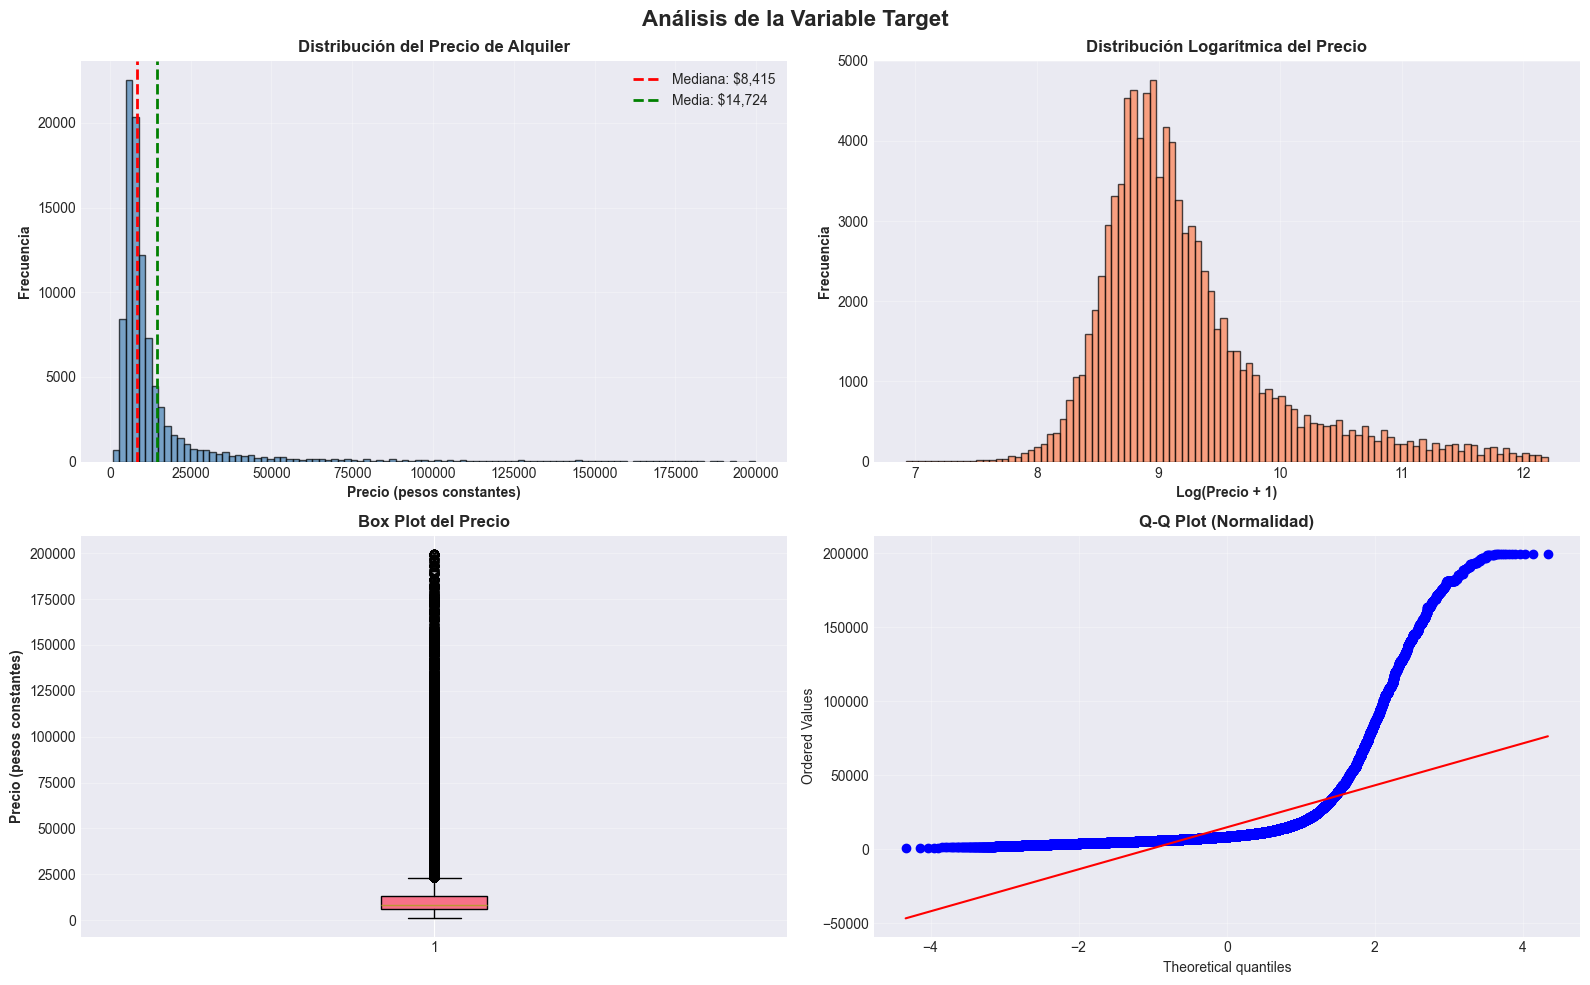


Estadísticas del target:
  Media: $14,723.90
  Mediana: $8,415.49
  Desviación estándar: $20,837.61
  Mínimo: $1,010.40
  Máximo: $199,695.79
  Asimetría: 4.56
  Curtosis: 24.74


In [23]:
# Visualización de la distribución del target
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Distribución del precio
axes[0, 0].hist(y, bins=100, alpha=0.7, color='steelblue', edgecolor='black')
axes[0, 0].axvline(y.median(), color='red', linestyle='--', linewidth=2, 
                   label=f'Mediana: ${y.median():,.0f}')
axes[0, 0].axvline(y.mean(), color='green', linestyle='--', linewidth=2,
                   label=f'Media: ${y.mean():,.0f}')
axes[0, 0].set_xlabel('Precio (pesos constantes)', fontweight='bold')
axes[0, 0].set_ylabel('Frecuencia', fontweight='bold')
axes[0, 0].set_title('Distribución del Precio de Alquiler', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Distribución logarítmica del precio
axes[0, 1].hist(np.log1p(y), bins=100, alpha=0.7, color='coral', edgecolor='black')
axes[0, 1].set_xlabel('Log(Precio + 1)', fontweight='bold')
axes[0, 1].set_ylabel('Frecuencia', fontweight='bold')
axes[0, 1].set_title('Distribución Logarítmica del Precio', fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Box plot del precio
axes[1, 0].boxplot(y, vert=True, patch_artist=True)
axes[1, 0].set_ylabel('Precio (pesos constantes)', fontweight='bold')
axes[1, 0].set_title('Box Plot del Precio', fontweight='bold')
axes[1, 0].grid(alpha=0.3, axis='y')

# Q-Q plot para normalidad
from scipy import stats
stats.probplot(y, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Normalidad)', fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.suptitle('Análisis de la Variable Target', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nEstadísticas del target:")
print(f"  Media: ${y.mean():,.2f}")
print(f"  Mediana: ${y.median():,.2f}")
print(f"  Desviación estándar: ${y.std():,.2f}")
print(f"  Mínimo: ${y.min():,.2f}")
print(f"  Máximo: ${y.max():,.2f}")
print(f"  Asimetría: {y.skew():.2f}")
print(f"  Curtosis: {y.kurtosis():.2f}")


## 2. Ingeniería de Features


In [24]:
# Analizar variables categóricas antes de encoding
print("=" * 100)
print("ANÁLISIS DE VARIABLES CATEGÓRICAS")
print("=" * 100)

for col in categorical_cols:
    if col in X.columns:
        unique_count = X[col].nunique()
        print(f"\n{col}:")
        print(f"  Valores únicos: {unique_count}")
        print(f"  Top 5 valores más frecuentes:")
        print(X[col].value_counts().head())


ANÁLISIS DE VARIABLES CATEGÓRICAS

ITE_ADD_CITY_NAME:
  Valores únicos: 39
  Top 5 valores más frecuentes:
ITE_ADD_CITY_NAME
Capital Federal    55177
La Matanza          5118
Tigre               3692
Vicente López       2966
Morón               2662
Name: count, dtype: int64

ITE_ADD_STATE_NAME:
  Valores únicos: 4
  Top 5 valores más frecuentes:
ITE_ADD_STATE_NAME
Capital Federal        55254
Bs.As. G.B.A. Norte    16320
Bs.As. G.B.A. Oeste    13517
Bs.As. G.B.A. Sur      10694
Name: count, dtype: int64

ITE_ADD_NEIGHBORHOOD_NAME:
  Valores únicos: 487
  Top 5 valores más frecuentes:
ITE_ADD_NEIGHBORHOOD_NAME
Palermo      5087
Belgrano     4528
Caballito    4499
Recoleta     4164
Unknown      3887
Name: count, dtype: int64

ITE_TIPO_PROD:
  Valores únicos: 3
  Top 5 valores más frecuentes:
ITE_TIPO_PROD
U    71583
S    12191
N    12011
Name: count, dtype: int64

estacion:
  Valores únicos: 4
  Top 5 valores más frecuentes:
estacion
verano       26456
otoño        23564
primavera    23

In [25]:
# Crear copia para transformaciones
X_processed = X.copy()

# Guardar nombres de columnas originales para referencia
original_columns = X_processed.columns.tolist()

# Verificar que las columnas categóricas existen
categorical_cols_in_X = [col for col in categorical_cols if col in X_processed.columns]
print(f"Columnas categóricas a procesar: {categorical_cols_in_X}")

# Aplicar One-Hot Encoding a variables categóricas
# Usaremos get_dummies de pandas para mayor control
X_encoded = pd.get_dummies(X_processed, columns=categorical_cols_in_X, prefix=categorical_cols_in_X, drop_first=False)

print(f"\nShape antes de encoding: {X_processed.shape}")
print(f"Shape después de encoding: {X_encoded.shape}")
print(f"Columnas nuevas creadas: {X_encoded.shape[1] - X_processed.shape[1]}")


Columnas categóricas a procesar: ['ITE_ADD_CITY_NAME', 'ITE_ADD_STATE_NAME', 'ITE_ADD_NEIGHBORHOOD_NAME', 'ITE_TIPO_PROD', 'estacion']

Shape antes de encoding: (95785, 30)
Shape después de encoding: (95785, 562)
Columnas nuevas creadas: 532


In [26]:
# Verificar tipos de datos después del encoding
print("Tipos de datos después del encoding:")
print(X_encoded.dtypes.value_counts())

# Verificar que no hay valores nulos
print(f"\nValores nulos: {X_encoded.isna().sum().sum()}")

# Mostrar algunas columnas nuevas creadas
new_categorical_cols = [col for col in X_encoded.columns if any(cat_col in col for cat_col in categorical_cols_in_X)]
print(f"\nEjemplos de columnas categóricas codificadas (primeras 10):")
print(new_categorical_cols[:10])


Tipos de datos después del encoding:
bool       537
float64     18
int64        7
Name: count, dtype: int64

Valores nulos: 0

Ejemplos de columnas categóricas codificadas (primeras 10):
['ITE_ADD_CITY_NAME_Almirante Brown', 'ITE_ADD_CITY_NAME_Avellaneda', 'ITE_ADD_CITY_NAME_Barracas', 'ITE_ADD_CITY_NAME_Beccar', 'ITE_ADD_CITY_NAME_Berazategui', 'ITE_ADD_CITY_NAME_Capital Federal', 'ITE_ADD_CITY_NAME_Caseros', 'ITE_ADD_CITY_NAME_Castelar', 'ITE_ADD_CITY_NAME_Escobar', 'ITE_ADD_CITY_NAME_Esteban Echeverría']


Top 15 features más correlacionadas con el target:
target             1.000000
STotalM2           0.694928
Banos              0.673678
Ambientes          0.514600
Cocheras           0.504328
Dormitorios        0.485952
tiene_cochera      0.417928
total_amenities    0.404502
Gimnasio           0.364217
Pileta             0.321673
Jacuzzi            0.286182
SalonDeUsosMul     0.252433
Seguridad          0.251358
Laundry            0.239481
AireAC             0.233534
Name: target, dtype: float64

Bottom 5 features menos correlacionadas:
AreaParrillas         0.085793
year                  0.055731
mes                   0.050101
Antiguedad            0.049872
Ascensor             -0.018022
densidad_ambientes   -0.361296
Name: target, dtype: float64


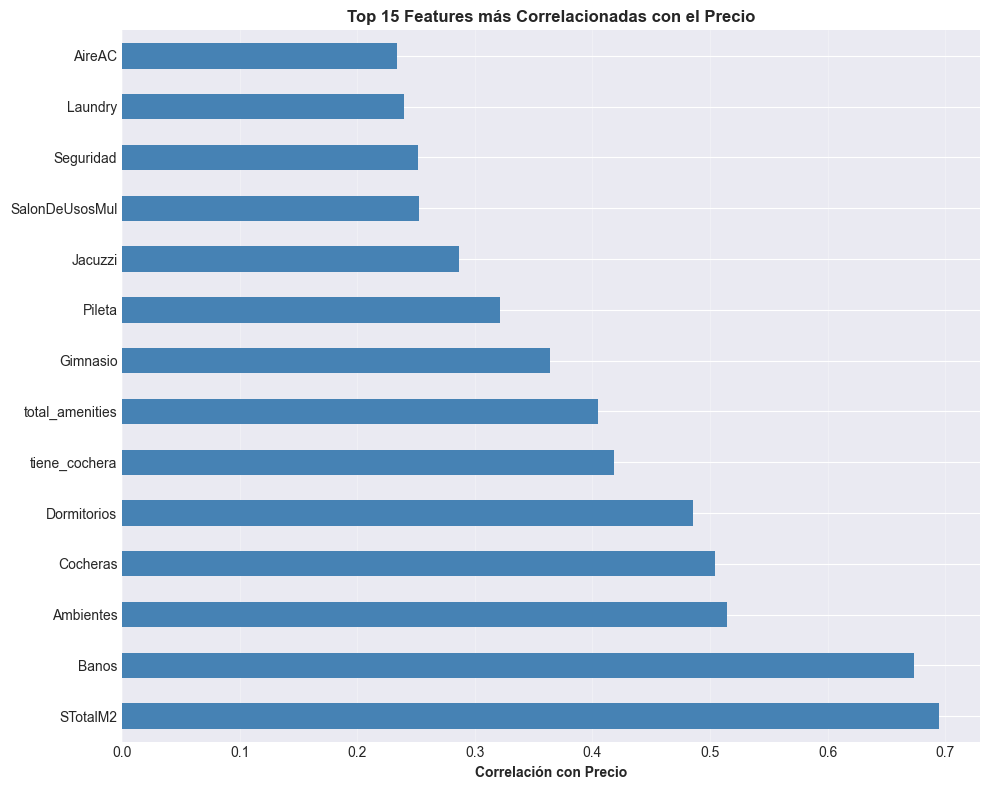

In [27]:
# Análisis de correlación con el target (antes de split)
# Crear DataFrame temporal con target para análisis
df_temp = X_encoded.copy()
df_temp['target'] = y

# Calcular correlaciones (solo numéricas)
numeric_cols_encoded = [col for col in X_encoded.columns if X_encoded[col].dtype in ['int64', 'float64']]
correlations = df_temp[numeric_cols_encoded + ['target']].corr()['target'].sort_values(ascending=False)

print("Top 15 features más correlacionadas con el target:")
print(correlations.head(15))
print("\nBottom 5 features menos correlacionadas:")
print(correlations.tail(6))  # Incluye el target mismo

# Visualización de correlaciones
plt.figure(figsize=(10, 8))
top_corr = correlations.head(15).drop('target')
top_corr.plot(kind='barh', color='steelblue')
plt.xlabel('Correlación con Precio', fontweight='bold')
plt.title('Top 15 Features más Correlacionadas con el Precio', fontweight='bold')
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Limpiar variable temporal
del df_temp


In [28]:
# Guardar nombres de columnas finales para uso posterior
feature_names = X_encoded.columns.tolist()
print(f"Total de features después de encoding: {len(feature_names)}")

# Actualizar X con datos procesados
X = X_encoded.copy()

print("✓ Feature engineering completado")
print(f"  Features finales: {X.shape[1]}")
print(f"  Registros: {X.shape[0]}")


Total de features después de encoding: 562
✓ Feature engineering completado
  Features finales: 562
  Registros: 95785


## 3. División de Datos


In [29]:
# Usar los conjuntos pre-divididos (train, validation, test)
# Los datasets ya fueron separados estratificadamente: 70% train, 20% val, 10% test
print("=" * 100)
print("PREPARACIÓN DE CONJUNTOS DE DATOS")
print("=" * 100)

# Separar features y target para train
X_train_raw = df_train.drop(columns=[target_col] + exclude_cols)
y_train = df_train[target_col]

# Separar features y target para validation
X_val_raw = df_val.drop(columns=[target_col] + exclude_cols)
y_val = df_val[target_col]

# Separar features y target para test (se usará al final)
X_test_final_raw = df_test.drop(columns=[target_col] + exclude_cols)
y_test_final = df_test[target_col]

print(f"\n✓ Conjuntos preparados (antes de encoding):")
print(f"  Train:      {X_train_raw.shape}")
print(f"  Validation: {X_val_raw.shape}")
print(f"  Test:       {X_test_final_raw.shape}")

# APLICAR ONE-HOT ENCODING A VARIABLES CATEGÓRICAS
print("\n" + "=" * 100)
print("APLICANDO ONE-HOT ENCODING")
print("=" * 100)

categorical_cols_in_X = [col for col in categorical_cols if col in X_train_raw.columns]
print(f"Columnas categóricas a procesar: {categorical_cols_in_X}")

# Aplicar encoding al train set primero
X_train_encoded = pd.get_dummies(X_train_raw, columns=categorical_cols_in_X, prefix=categorical_cols_in_X, drop_first=False)

# Verificar y ordenar columnas para consistencia
numeric_binary_cols = numeric_cols + binary_cols
numeric_binary_cols_in_X = [col for col in numeric_binary_cols if col in X_train_encoded.columns]
categorical_encoded_cols = [col for col in X_train_encoded.columns if col not in numeric_binary_cols_in_X]

# Reordenar: primero numéricas/binarias, luego categóricas codificadas (ordenadas alfabéticamente)
X_train_encoded = X_train_encoded[numeric_binary_cols_in_X + sorted(categorical_encoded_cols)]

# Guardar nombres de columnas finales para uso posterior
feature_names = X_train_encoded.columns.tolist()
print(f"\n✓ Train set después de encoding: {X_train_encoded.shape}")
print(f"  Total de features: {len(feature_names)}")

# Aplicar encoding al validation set (mismo proceso)
X_val_encoded = pd.get_dummies(X_val_raw, columns=categorical_cols_in_X, prefix=categorical_cols_in_X, drop_first=False)
numeric_binary_cols_in_X_val = [col for col in numeric_binary_cols if col in X_val_encoded.columns]
categorical_encoded_cols_val = [col for col in X_val_encoded.columns if col not in numeric_binary_cols_in_X_val]
X_val_encoded = X_val_encoded[numeric_binary_cols_in_X_val + sorted(categorical_encoded_cols_val)]

# Asegurar que todas las columnas necesarias estén presentes en validation
for feature in feature_names:
    if feature not in X_val_encoded.columns:
        X_val_encoded[feature] = 0

# Eliminar columnas extra que no están en feature_names
columns_to_drop_val = [col for col in X_val_encoded.columns if col not in feature_names]
if columns_to_drop_val:
    X_val_encoded = X_val_encoded.drop(columns=columns_to_drop_val)

# Reordenar columnas para que coincidan con el orden del entrenamiento
X_val_encoded = X_val_encoded[feature_names]

print(f"✓ Validation set después de encoding: {X_val_encoded.shape}")

# Aplicar encoding al test set (mismo proceso)
X_test_encoded = pd.get_dummies(X_test_final_raw, columns=categorical_cols_in_X, prefix=categorical_cols_in_X, drop_first=False)
numeric_binary_cols_in_X_test = [col for col in numeric_binary_cols if col in X_test_encoded.columns]
categorical_encoded_cols_test = [col for col in X_test_encoded.columns if col not in numeric_binary_cols_in_X_test]
X_test_encoded = X_test_encoded[numeric_binary_cols_in_X_test + sorted(categorical_encoded_cols_test)]

# Asegurar que todas las columnas necesarias estén presentes en test
for feature in feature_names:
    if feature not in X_test_encoded.columns:
        X_test_encoded[feature] = 0

# Eliminar columnas extra que no están en feature_names
columns_to_drop_test = [col for col in X_test_encoded.columns if col not in feature_names]
if columns_to_drop_test:
    X_test_encoded = X_test_encoded.drop(columns=columns_to_drop_test)

# Reordenar columnas para que coincidan con el orden del entrenamiento
X_test_encoded = X_test_encoded[feature_names]

print(f"✓ Test set después de encoding: {X_test_encoded.shape}")

# Asignar a variables finales
X_train = X_train_encoded.copy()
X_val = X_val_encoded.copy()
X_test_final = X_test_encoded.copy()

print(f"\n✓ Conjuntos finales preparados:")
print(f"\nConjunto de entrenamiento (70%):")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  Media del target: ${y_train.mean():,.2f}")

print(f"\nConjunto de validación (20%):")
print(f"  X_val: {X_val.shape}")
print(f"  y_val: {y_val.shape}")
print(f"  Media del target: ${y_val.mean():,.2f}")

print(f"\nConjunto de test (10%) - reservado para evaluación final:")
print(f"  X_test: {X_test_final.shape}")
print(f"  y_test: {y_test_final.shape}")
print(f"  Media del target: ${y_test_final.mean():,.2f}")


PREPARACIÓN DE CONJUNTOS DE DATOS

✓ Conjuntos preparados (antes de encoding):
  Train:      (67068, 30)
  Validation: (19138, 30)
  Test:       (9579, 30)

APLICANDO ONE-HOT ENCODING
Columnas categóricas a procesar: ['ITE_ADD_CITY_NAME', 'ITE_ADD_STATE_NAME', 'ITE_ADD_NEIGHBORHOOD_NAME', 'ITE_TIPO_PROD', 'estacion']

✓ Train set después de encoding: (67068, 525)
  Total de features: 525
✓ Validation set después de encoding: (19138, 525)
✓ Test set después de encoding: (9579, 525)

✓ Conjuntos finales preparados:

Conjunto de entrenamiento (70%):
  X_train: (67068, 525)
  y_train: (67068,)
  Media del target: $14,738.50

Conjunto de validación (20%):
  X_val: (19138, 525)
  y_val: (19138,)
  Media del target: $14,767.61

Conjunto de test (10%) - reservado para evaluación final:
  X_test: (9579, 525)
  y_test: (9579,)
  Media del target: $14,534.41


## 4. Selección y Entrenamiento de Modelos


In [30]:
# Función para calcular métricas de evaluación
def evaluate_model(y_true, y_pred, model_name=""):
    """Calcula múltiples métricas de evaluación"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE': mape
    }

# Función para imprimir métricas
def print_metrics(metrics, model_name=""):
    """Imprime métricas formateadas"""
    print(f"\n{'='*60}")
    print(f"Métricas - {model_name}")
    print(f"{'='*60}")
    print(f"  RMSE:  ${metrics['RMSE']:,.2f}")
    print(f"  MAE:   ${metrics['MAE']:,.2f}")
    print(f"  R²:    {metrics['R²']:.4f}")
    print(f"  MAPE:  {metrics['MAPE']:.2f}%")
    print(f"{'='*60}")

print("✓ Funciones de evaluación definidas")


✓ Funciones de evaluación definidas


In [31]:
# Diccionario para almacenar resultados de modelos
model_results = {}

# 1. Linear Regression (Baseline)
print("\n" + "="*100)
print("ENTRENANDO: Linear Regression")
print("="*100)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predicciones
y_train_pred_lr = lr_model.predict(X_train)
y_val_pred_lr = lr_model.predict(X_val)

# Evaluación
train_metrics_lr = evaluate_model(y_train, y_train_pred_lr, "Linear Regression - Train")
val_metrics_lr = evaluate_model(y_val, y_val_pred_lr, "Linear Regression - Validation")

print_metrics(train_metrics_lr, "Linear Regression - Train")
print_metrics(val_metrics_lr, "Linear Regression - Validation")

# Guardar resultados
model_results['Linear Regression'] = {
    'model': lr_model,
    'train_metrics': train_metrics_lr,
    'val_metrics': val_metrics_lr,
    'y_train_pred': y_train_pred_lr,
    'y_val_pred': y_val_pred_lr
}



ENTRENANDO: Linear Regression

Métricas - Linear Regression - Train
  RMSE:  $11,210.16
  MAE:   $5,717.50
  R²:    0.7120
  MAPE:  47.81%

Métricas - Linear Regression - Validation
  RMSE:  $11,539.38
  MAE:   $5,801.30
  R²:    0.7000
  MAPE:  48.74%


In [32]:
# 2. Random Forest Regressor
print("\n" + "="*100)
print("ENTRENANDO: Random Forest Regressor")
print("="*100)

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)

rf_model.fit(X_train, y_train)

# Predicciones
y_train_pred_rf = rf_model.predict(X_train)
y_val_pred_rf = rf_model.predict(X_val)

# Evaluación
train_metrics_rf = evaluate_model(y_train, y_train_pred_rf, "Random Forest - Train")
val_metrics_rf = evaluate_model(y_val, y_val_pred_rf, "Random Forest - Validation")

print_metrics(train_metrics_rf, "Random Forest - Train")
print_metrics(val_metrics_rf, "Random Forest - Validation")

# Guardar resultados
model_results['Random Forest'] = {
    'model': rf_model,
    'train_metrics': train_metrics_rf,
    'val_metrics': val_metrics_rf,
    'y_train_pred': y_train_pred_rf,
    'y_val_pred': y_val_pred_rf
}



ENTRENANDO: Random Forest Regressor

Métricas - Random Forest - Train
  RMSE:  $4,042.74
  MAE:   $1,789.77
  R²:    0.9625
  MAPE:  12.54%

Métricas - Random Forest - Validation
  RMSE:  $7,610.69
  MAE:   $3,185.94
  R²:    0.8695
  MAPE:  19.95%


In [33]:
# 3. XGBoost Regressor
print("\n" + "="*100)
print("ENTRENANDO: XGBoost Regressor")
print("="*100)

xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=0
)

xgb_model.fit(X_train, y_train)

# Predicciones
y_train_pred_xgb = xgb_model.predict(X_train)
y_val_pred_xgb = xgb_model.predict(X_val)

# Evaluación
train_metrics_xgb = evaluate_model(y_train, y_train_pred_xgb, "XGBoost - Train")
val_metrics_xgb = evaluate_model(y_val, y_val_pred_xgb, "XGBoost - Validation")

print_metrics(train_metrics_xgb, "XGBoost - Train")
print_metrics(val_metrics_xgb, "XGBoost - Validation")

# Guardar resultados
model_results['XGBoost'] = {
    'model': xgb_model,
    'train_metrics': train_metrics_xgb,
    'val_metrics': val_metrics_xgb,
    'y_train_pred': y_train_pred_xgb,
    'y_val_pred': y_val_pred_xgb
}



ENTRENANDO: XGBoost Regressor

Métricas - XGBoost - Train
  RMSE:  $6,479.26
  MAE:   $2,979.48
  R²:    0.9038
  MAPE:  20.39%

Métricas - XGBoost - Validation
  RMSE:  $7,696.81
  MAE:   $3,319.06
  R²:    0.8665
  MAPE:  21.31%


In [34]:
# 4. Gradient Boosting Regressor
print("\n" + "="*100)
print("ENTRENANDO: Gradient Boosting Regressor")
print("="*100)

gb_model = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    random_state=RANDOM_STATE,
    verbose=0
)

gb_model.fit(X_train, y_train)

# Predicciones
y_train_pred_gb = gb_model.predict(X_train)
y_val_pred_gb = gb_model.predict(X_val)

# Evaluación
train_metrics_gb = evaluate_model(y_train, y_train_pred_gb, "Gradient Boosting - Train")
val_metrics_gb = evaluate_model(y_val, y_val_pred_gb, "Gradient Boosting - Validation")

print_metrics(train_metrics_gb, "Gradient Boosting - Train")
print_metrics(val_metrics_gb, "Gradient Boosting - Validation")

# Guardar resultados
model_results['Gradient Boosting'] = {
    'model': gb_model,
    'train_metrics': train_metrics_gb,
    'val_metrics': val_metrics_gb,
    'y_train_pred': y_train_pred_gb,
    'y_val_pred': y_val_pred_gb
}



ENTRENANDO: Gradient Boosting Regressor

Métricas - Gradient Boosting - Train
  RMSE:  $6,853.16
  MAE:   $3,147.69
  R²:    0.8923
  MAPE:  21.36%

Métricas - Gradient Boosting - Validation
  RMSE:  $7,883.06
  MAE:   $3,405.75
  R²:    0.8600
  MAPE:  22.12%


In [35]:
# Comparación de modelos
print("\n" + "="*100)
print("COMPARACIÓN DE MODELOS - MÉTRICAS DE VALIDACIÓN")
print("="*100)

comparison_df = pd.DataFrame({
    model_name: {
        'RMSE': results['val_metrics']['RMSE'],
        'MAE': results['val_metrics']['MAE'],
        'R²': results['val_metrics']['R²'],
        'MAPE': results['val_metrics']['MAPE']
    }
    for model_name, results in model_results.items()
}).T

comparison_df = comparison_df.sort_values('RMSE')
print("\n" + comparison_df.to_string())

# Identificar mejor modelo
best_model_name = comparison_df.index[0]
print(f"\n✓ Mejor modelo según RMSE: {best_model_name}")
print(f"  RMSE: ${comparison_df.loc[best_model_name, 'RMSE']:,.2f}")
print(f"  R²: {comparison_df.loc[best_model_name, 'R²']:.4f}")



COMPARACIÓN DE MODELOS - MÉTRICAS DE VALIDACIÓN

                           RMSE          MAE        R²       MAPE
Random Forest       7610.692424  3185.935091  0.869481  19.945093
XGBoost             7696.805286  3319.063739  0.866511  21.309068
Gradient Boosting   7883.059902  3405.751996  0.859972  22.122204
Linear Regression  11539.378795  5801.296705  0.699953  48.742149

✓ Mejor modelo según RMSE: Random Forest
  RMSE: $7,610.69
  R²: 0.8695


## 5. Evaluación de Modelos


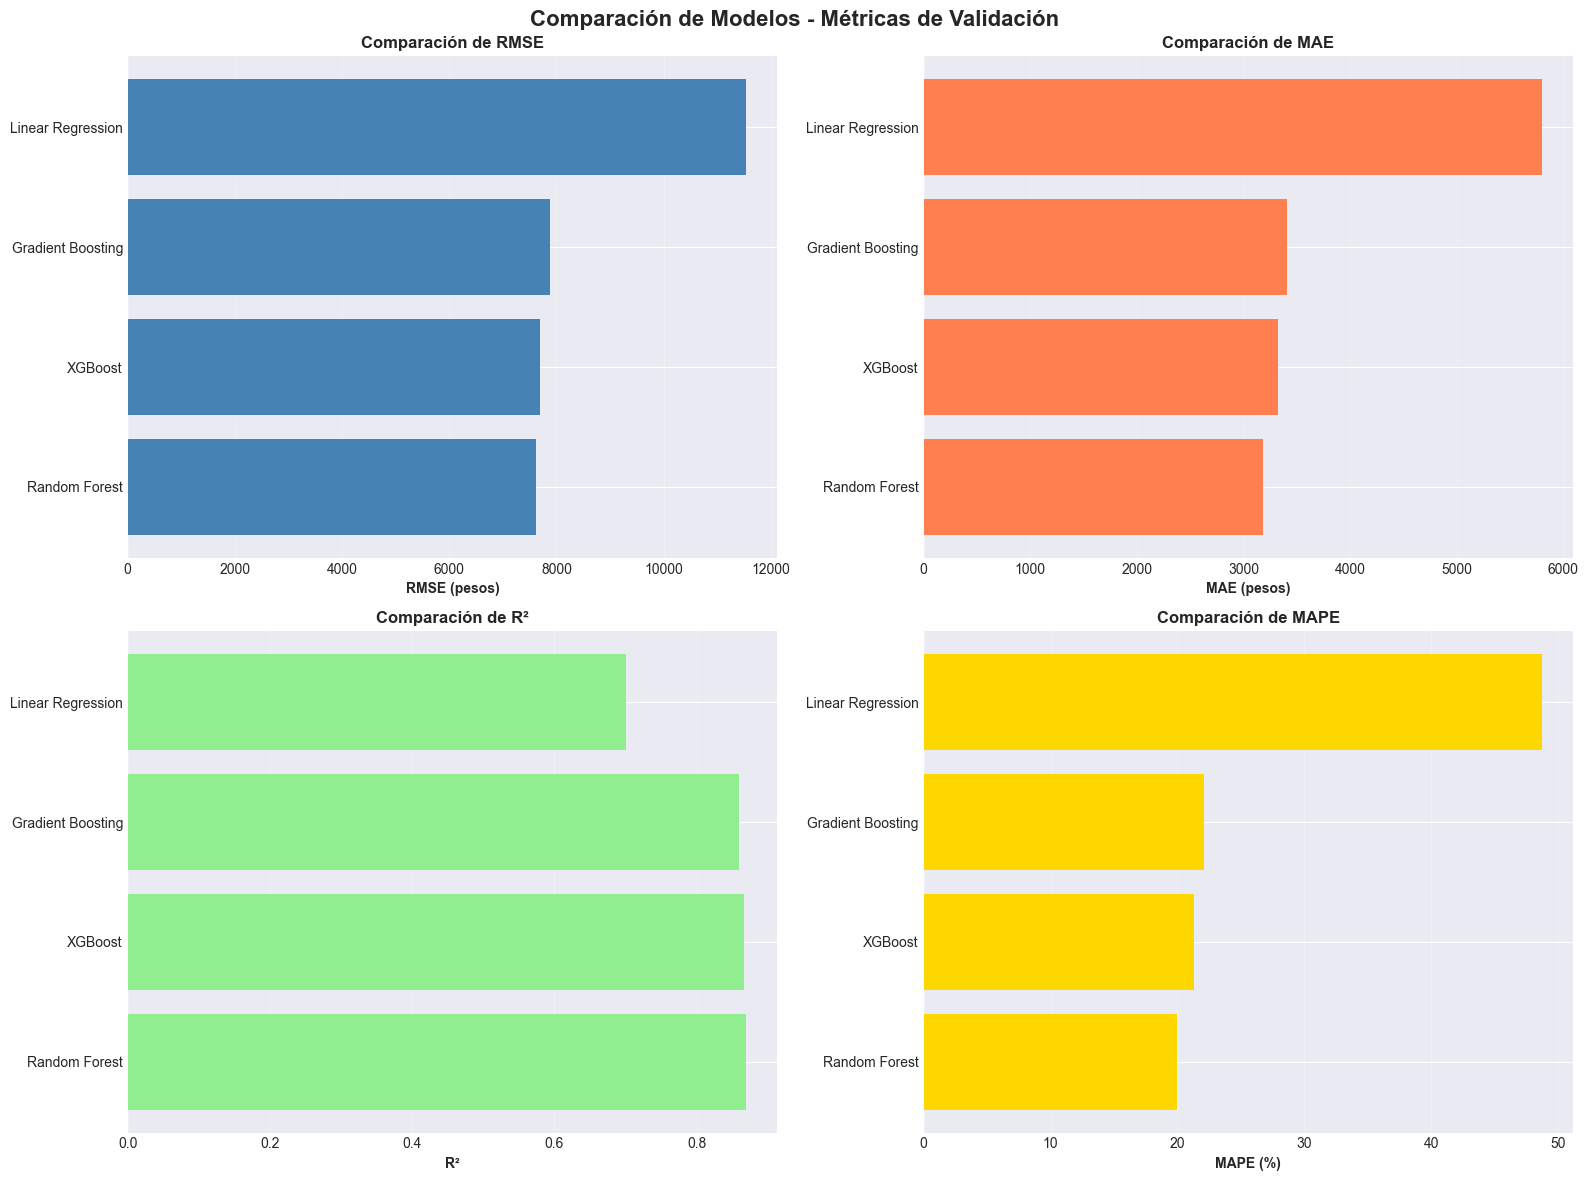

In [36]:
# Visualización: Comparación de métricas
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# RMSE
axes[0, 0].barh(comparison_df.index, comparison_df['RMSE'], color='steelblue')
axes[0, 0].set_xlabel('RMSE (pesos)', fontweight='bold')
axes[0, 0].set_title('Comparación de RMSE', fontweight='bold')
axes[0, 0].grid(alpha=0.3, axis='x')

# MAE
axes[0, 1].barh(comparison_df.index, comparison_df['MAE'], color='coral')
axes[0, 1].set_xlabel('MAE (pesos)', fontweight='bold')
axes[0, 1].set_title('Comparación de MAE', fontweight='bold')
axes[0, 1].grid(alpha=0.3, axis='x')

# R²
axes[1, 0].barh(comparison_df.index, comparison_df['R²'], color='lightgreen')
axes[1, 0].set_xlabel('R²', fontweight='bold')
axes[1, 0].set_title('Comparación de R²', fontweight='bold')
axes[1, 0].grid(alpha=0.3, axis='x')

# MAPE
axes[1, 1].barh(comparison_df.index, comparison_df['MAPE'], color='gold')
axes[1, 1].set_xlabel('MAPE (%)', fontweight='bold')
axes[1, 1].set_title('Comparación de MAPE', fontweight='bold')
axes[1, 1].grid(alpha=0.3, axis='x')

plt.suptitle('Comparación de Modelos - Métricas de Validación', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


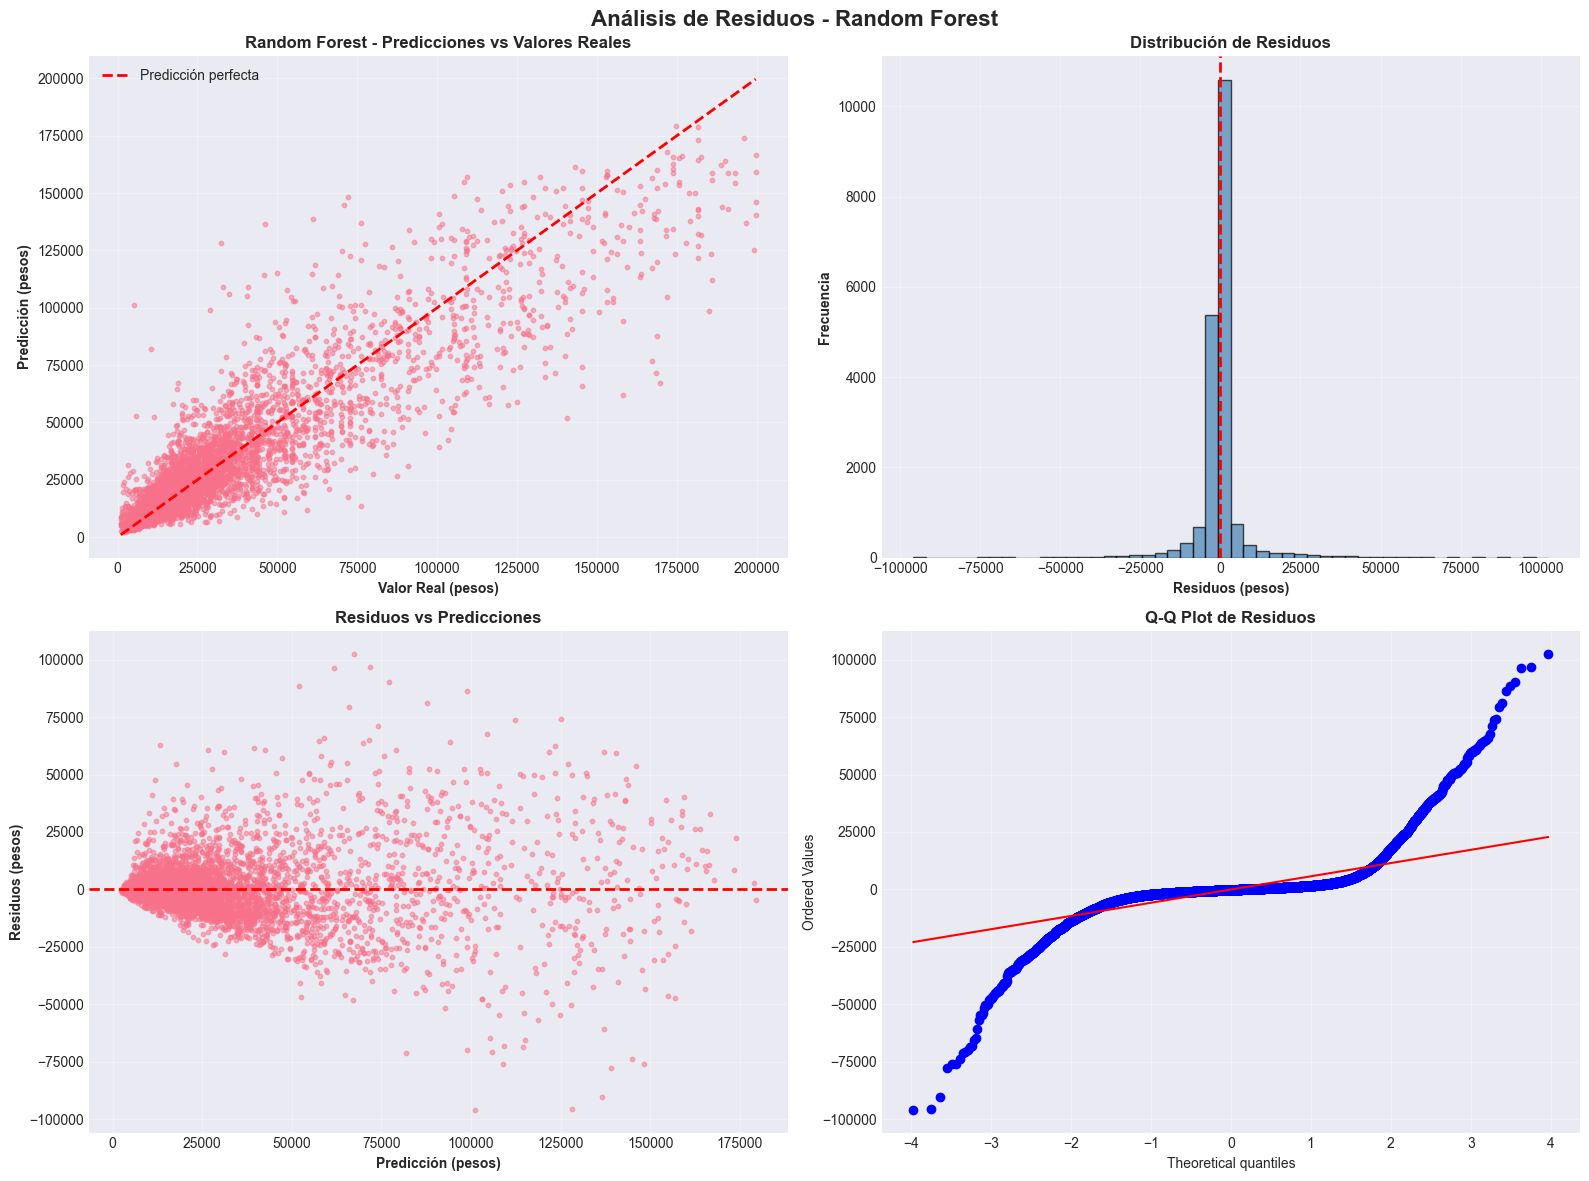


Estadísticas de residuos:
  Media: $-84.72
  Desviación estándar: $7,610.42
  Mínimo: $-95,974.46
  Máximo: $102,411.65


In [37]:
# Visualización: Predicciones vs Valores Reales (mejor modelo)
best_model_results = model_results[best_model_name]
y_val_pred_best = best_model_results['y_val_pred']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Scatter plot: Predicciones vs Valores reales
axes[0, 0].scatter(y_val, y_val_pred_best, alpha=0.5, s=10)
axes[0, 0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2, label='Predicción perfecta')
axes[0, 0].set_xlabel('Valor Real (pesos)', fontweight='bold')
axes[0, 0].set_ylabel('Predicción (pesos)', fontweight='bold')
axes[0, 0].set_title(f'{best_model_name} - Predicciones vs Valores Reales', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Distribución de residuos
residuals = y_val - y_val_pred_best
axes[0, 1].hist(residuals, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Residuos (pesos)', fontweight='bold')
axes[0, 1].set_ylabel('Frecuencia', fontweight='bold')
axes[0, 1].set_title('Distribución de Residuos', fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Residuos vs Predicciones
axes[1, 0].scatter(y_val_pred_best, residuals, alpha=0.5, s=10)
axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicción (pesos)', fontweight='bold')
axes[1, 0].set_ylabel('Residuos (pesos)', fontweight='bold')
axes[1, 0].set_title('Residuos vs Predicciones', fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Q-Q plot de residuos
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot de Residuos', fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.suptitle(f'Análisis de Residuos - {best_model_name}', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nEstadísticas de residuos:")
print(f"  Media: ${residuals.mean():,.2f}")
print(f"  Desviación estándar: ${residuals.std():,.2f}")
print(f"  Mínimo: ${residuals.min():,.2f}")
print(f"  Máximo: ${residuals.max():,.2f}")


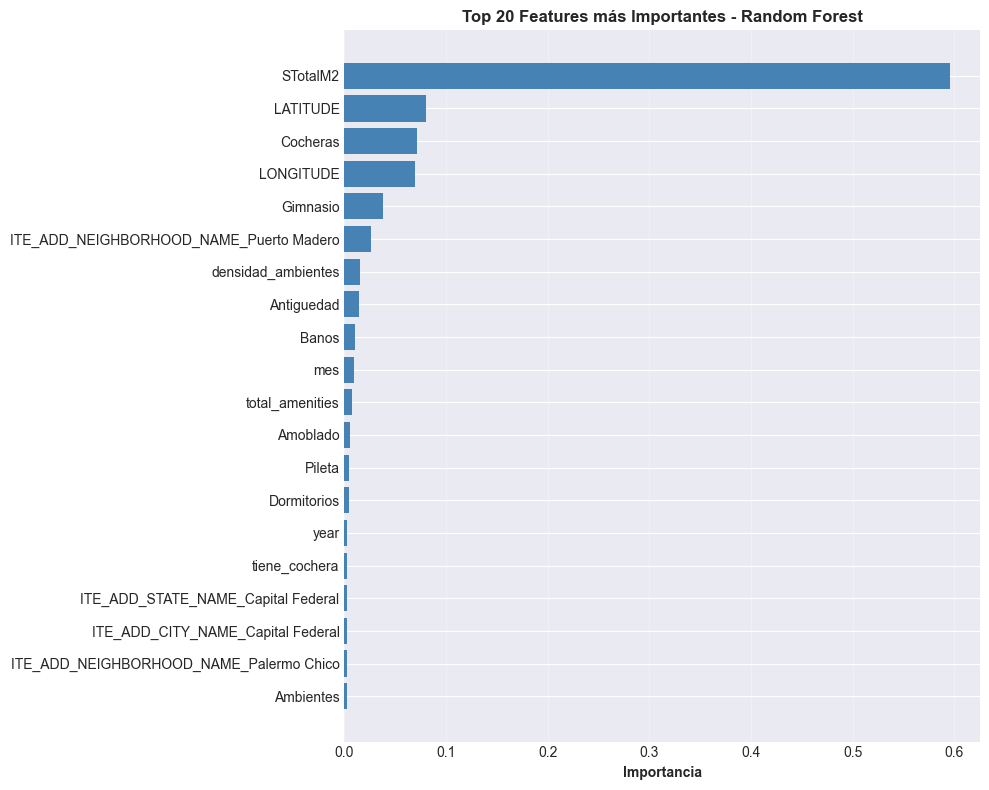


Top 10 features más importantes:
                                feature  importance
                               STotalM2    0.595627
                               LATITUDE    0.079759
                               Cocheras    0.070949
                              LONGITUDE    0.069214
                               Gimnasio    0.037494
ITE_ADD_NEIGHBORHOOD_NAME_Puerto Madero    0.026066
                     densidad_ambientes    0.015052
                             Antiguedad    0.014439
                                  Banos    0.010815
                                    mes    0.008983


In [38]:
# Feature Importance (para modelos tree-based)
if best_model_name in ['Random Forest', 'XGBoost', 'Gradient Boosting']:
    best_model = model_results[best_model_name]['model']
    
    if hasattr(best_model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        # Top 20 features más importantes
        top_features = feature_importance.head(20)
        
        plt.figure(figsize=(10, 8))
        plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Importancia', fontweight='bold')
        plt.title(f'Top 20 Features más Importantes - {best_model_name}', fontweight='bold')
        plt.gca().invert_yaxis()
        plt.grid(alpha=0.3, axis='x')
        plt.tight_layout()
        plt.show()
        
        print(f"\nTop 10 features más importantes:")
        print(top_features.head(10).to_string(index=False))


## 6. Optimización de Hiperparámetros


In [39]:
# Optimización de hiperparámetros para el mejor modelo
print("=" * 100)
print(f"OPTIMIZACIÓN DE HIPERPARÁMETROS - {best_model_name}")
print("=" * 100)

# Definir grid de hiperparámetros según el modelo
if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [15, 20, 25],
        'min_samples_split': [5, 10],
        'min_samples_leaf': [2, 4]
    }
    base_model = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbose=0)
    
elif best_model_name == 'XGBoost':
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [5, 6, 7],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 0.9]
    }
    base_model = xgb.XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbosity=0)
    
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [4, 5, 6],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 0.9]
    }
    base_model = GradientBoostingRegressor(random_state=RANDOM_STATE, verbose=0)
    
else:
    print(f"Optimización de hiperparámetros no implementada para {best_model_name}")
    param_grid = None
    base_model = None

if param_grid is not None:
    # Usar RandomizedSearchCV para ser más eficiente
    print(f"\nBuscando mejores hiperparámetros...")
    print(f"Combinaciones a probar: {len(param_grid)} parámetros")
    
    grid_search = RandomizedSearchCV(
        base_model,
        param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_iter=20,  # Reducido para velocidad, aumentar si hay tiempo
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"\n✓ Mejores hiperparámetros encontrados:")
    print(grid_search.best_params_)
    print(f"\nMejor score (neg MSE): {grid_search.best_score_:,.2f}")
    
    # Entrenar modelo con mejores hiperparámetros
    best_tuned_model = grid_search.best_estimator_
    
    # Evaluar modelo optimizado
    y_val_pred_tuned = best_tuned_model.predict(X_val)
    val_metrics_tuned = evaluate_model(y_val, y_val_pred_tuned, f"{best_model_name} - Tuned")
    
    print_metrics(val_metrics_tuned, f"{best_model_name} - Optimizado")
    
    # Comparar con modelo original
    print(f"\nComparación:")
    print(f"  RMSE original: ${model_results[best_model_name]['val_metrics']['RMSE']:,.2f}")
    print(f"  RMSE optimizado: ${val_metrics_tuned['RMSE']:,.2f}")
    improvement = ((model_results[best_model_name]['val_metrics']['RMSE'] - val_metrics_tuned['RMSE']) / 
                   model_results[best_model_name]['val_metrics']['RMSE']) * 100
    print(f"  Mejora: {improvement:.2f}%")
    
    # Actualizar mejor modelo si hay mejora
    if val_metrics_tuned['RMSE'] < model_results[best_model_name]['val_metrics']['RMSE']:
        model_results[best_model_name]['model'] = best_tuned_model
        model_results[best_model_name]['val_metrics'] = val_metrics_tuned
        model_results[best_model_name]['y_val_pred'] = y_val_pred_tuned
        print(f"\n✓ Modelo optimizado guardado como mejor modelo")
    else:
        print(f"\n⚠️ El modelo original es mejor, manteniendo modelo original")


OPTIMIZACIÓN DE HIPERPARÁMETROS - Random Forest

Buscando mejores hiperparámetros...
Combinaciones a probar: 4 parámetros
Fitting 5 folds for each of 20 candidates, totalling 100 fits


KeyboardInterrupt: 

## 7. Evaluación Final con Test Set


In [ ]:
# EVALUACIÓN FINAL EN TEST SET (10%)
print("=" * 100)
print("EVALUACIÓN FINAL - TEST SET (10%)")
print("=" * 100)

# X_test_final ya está codificado y preparado desde la sección de preparación de datos
print(f"\n✓ Test set ya preparado: {X_test_final.shape}")
print(f"  Features: {len(feature_names)}")

# Hacer predicciones con el mejor modelo
best_model_final = model_results[best_model_name]['model']
y_test_pred = best_model_final.predict(X_test_final)

print(f"\n✓ Predicciones completadas: {len(y_test_pred):,} predicciones")

# Evaluar métricas
test_metrics = evaluate_model(y_test_final, y_test_pred, f"{best_model_name} - Test")
print_metrics(test_metrics, f"{best_model_name} - Test Set")

# Comparación de métricas entre conjuntos
print("\n" + "=" * 100)
print("COMPARACIÓN: TRAIN vs VALIDATION vs TEST")
print("=" * 100)

comparison_final = pd.DataFrame({
    'Train': model_results[best_model_name]['train_metrics'],
    'Validation': model_results[best_model_name]['val_metrics'],
    'Test': test_metrics
}).T

print("\n" + comparison_final.to_string())

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Scatter plot test set
axes[0, 0].scatter(y_test_final, y_test_pred, alpha=0.5, s=10)
axes[0, 0].plot([y_test_final.min(), y_test_final.max()], [y_test_final.min(), y_test_final.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Valor Real (pesos)', fontweight='bold')
axes[0, 0].set_ylabel('Predicción (pesos)', fontweight='bold')
axes[0, 0].set_title(f'{best_model_name} - Test Set: Predicciones vs Reales', fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# Distribución de residuos
residuals_test = y_test_final - y_test_pred
axes[0, 1].hist(residuals_test, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Residuos (pesos)', fontweight='bold')
axes[0, 1].set_ylabel('Frecuencia', fontweight='bold')
axes[0, 1].set_title('Distribución de Residuos - Test Set', fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Comparación de métricas
metrics_to_plot = ['RMSE', 'MAE', 'R²']
x = np.arange(len(metrics_to_plot))
width = 0.25
axes[1, 0].bar(x - width, [model_results[best_model_name]['train_metrics'][m] for m in metrics_to_plot], width, label='Train', color='lightblue')
axes[1, 0].bar(x, [model_results[best_model_name]['val_metrics'][m] for m in metrics_to_plot], width, label='Validation', color='steelblue')
axes[1, 0].bar(x + width, [test_metrics[m] for m in metrics_to_plot], width, label='Test', color='darkblue')
axes[1, 0].set_xlabel('Métricas', fontweight='bold')
axes[1, 0].set_ylabel('Valor', fontweight='bold')
axes[1, 0].set_title('Comparación de Métricas: Train vs Val vs Test', fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(metrics_to_plot)
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3, axis='y')

# Residuos vs Predicciones
axes[1, 1].scatter(y_test_pred, residuals_test, alpha=0.5, s=10)
axes[1, 1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Predicción (pesos)', fontweight='bold')
axes[1, 1].set_ylabel('Residuos (pesos)', fontweight='bold')
axes[1, 1].set_title('Residuos vs Predicciones - Test Set', fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.suptitle(f'Evaluación Final - {best_model_name}', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n✓ Evaluación final completada")
print(f"  RMSE Test: ${test_metrics['RMSE']:,.2f}")
print(f"  R² Test: {test_metrics['R²']:.4f}")


PROCESAMIENTO DEL TEST SET

Test set original: (30481, 45)
⚠️ Test set NO incluye target - solo se harán predicciones

Aplicando pipeline de transformación...
Transformaciones aplicadas: 30481 → 23025 registros
Test set después de transformaciones: (23025, 33)

Test set preparado para predicción: (23025, 563)

PREDICCIONES EN TEST SET

✓ Predicciones completadas: 23,025 predicciones
  Rango de predicciones: [$2,434.16, $186,076.71]
  Media de predicciones: $18,507.50
  Mediana de predicciones: $8,778.87

✓ Predicciones guardadas en: output/test_predictions.csv


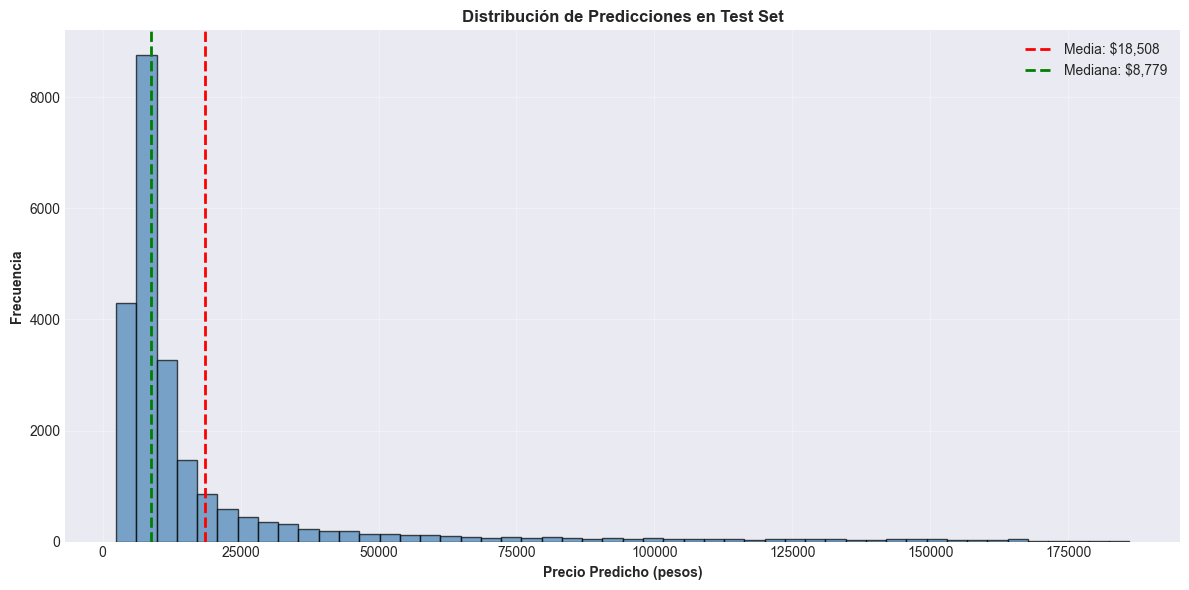

In [ ]:
# Función para aplicar el pipeline de transformación al test set
def apply_transformation_pipeline(df, has_target=True):
    """
    Aplica el mismo pipeline de transformación usado en transformation-pipeline.ipynb
    
    Parameters:
    -----------
    df : DataFrame
        Dataset a transformar
    has_target : bool
        Si True, asume que existe la columna 'precio_pesos_constantes' (target)
        Si False, omite los pasos que requieren el target
    """
    df_clean = df.copy()
    initial_rows = len(df_clean)
    
    # 1. Eliminar duplicados exactos
    df_clean = df_clean.drop_duplicates()
    
    # 2. Eliminar re-listings (mismo inmueble en múltiples meses)
    df_clean['MesListing'] = pd.to_datetime(df_clean['MesListing'])
    df_clean = df_clean.sort_values('MesListing', ascending=False)
    key_cols = ['LONGITUDE', 'LATITUDE', 'STotalM2', 'SConstrM2', 
                'Dormitorios', 'Banos', 'Ambientes']
    df_clean = df_clean.drop_duplicates(subset=key_cols, keep='first')
    
    # 3. Filtrar registros con datos críticos faltantes
    critical_cols = ['LONGITUDE', 'LATITUDE']
    if has_target and 'precio_pesos_constantes' in df_clean.columns:
        critical_cols.append('precio_pesos_constantes')
    df_clean = df_clean.dropna(subset=critical_cols)
    
    # 4. Separar RENT vs SALE (solo si tenemos target)
    if has_target and 'precio_pesos_constantes' in df_clean.columns:
        df_clean['price_per_m2_temp'] = df_clean['precio_pesos_constantes'] / df_clean['STotalM2']
        rent_filter = df_clean['precio_pesos_constantes'] <= 500000
        df_clean = df_clean[rent_filter].copy()
        price_m2_filter = df_clean['price_per_m2_temp'] <= 1000
        df_clean = df_clean[price_m2_filter].copy()
        df_clean = df_clean.drop(columns=['price_per_m2_temp'])
        
        # 5. Filtrar outliers de precio (solo si tenemos target)
        price_filter = (df_clean['precio_pesos_constantes'] >= 1000) & \
                       (df_clean['precio_pesos_constantes'] <= 200000)
        df_clean = df_clean[price_filter].copy()
    
    size_filter = (df_clean['STotalM2'] > 0) & (df_clean['STotalM2'] <= 1000)
    df_clean = df_clean[size_filter].copy()
    
    sconstr_filter = (df_clean['SConstrM2'] > 0) & \
                     (df_clean['SConstrM2'] <= 1000) & \
                     (df_clean['SConstrM2'] <= df_clean['STotalM2'])
    df_clean = df_clean[sconstr_filter].copy()
    
    dorm_filter = (df_clean['Dormitorios'] >= 0) & (df_clean['Dormitorios'] <= 8)
    df_clean = df_clean[dorm_filter].copy()
    
    banos_filter = (df_clean['Banos'] >= 1) & (df_clean['Banos'] <= 6)
    df_clean = df_clean[banos_filter].copy()
    
    ambientes_filter = (df_clean['Ambientes'] >= 0) & (df_clean['Ambientes'] <= 10)
    df_clean = df_clean[ambientes_filter].copy()
    
    cocheras_filter = (df_clean['Cocheras'] >= 0) & (df_clean['Cocheras'] <= 10)
    df_clean = df_clean[cocheras_filter].copy()
    
    consistency_filter = df_clean['Dormitorios'] <= df_clean['Ambientes']
    df_clean = df_clean[consistency_filter].copy()
    
    # 6. Eliminar columnas irrelevantes
    cols_to_drop = ['TIPOPROPIEDAD', 'SitioOrigen', 'PistaJogging', 'Lobby', 
                    'LocalesComerciales', 'BusinessCenter', 'Chimenea', 'CanchaTennis',
                    'SalonFiestas', 'Estacionamiento', 'EstacionamientoVisitas',
                    'Recepcion', 'Cisterna', 'AreaJuegosInfantiles', 'AreaCine',
                    'SistContraIncendios', 'SConstrM2']
    df_clean = df_clean.drop(columns=[col for col in cols_to_drop if col in df_clean.columns])
    
    # 7. Limpiar Antiguedad
    def clean_antiguedad(value):
        if pd.isna(value):
            return np.nan
        value_str = str(value).strip()
        if value_str in ['0', '0.0', '0 años']:
            return 0
        import re
        match = re.search(r'(\d+)', value_str)
        if match:
            years = int(match.group(1))
            return years if years <= 200 else np.nan
        return np.nan
    
    df_clean['Antiguedad'] = df_clean['Antiguedad'].apply(clean_antiguedad)
    
    # 8. Estandarizar amenities binarias
    def standardize_binary(value):
        if pd.isna(value):
            return np.nan
        value_str = str(value).strip().lower()
        if value_str in ['sí', 'si', '1', '1.0']:
            return 1
        if value_str in ['no', '0', '0.0', ' 0']:
            return 0
        return np.nan
    
    amenity_cols = ['Amoblado', 'AccesoInternet', 'Gimnasio', 'Laundry', 'Calefaccion',
                    'SalonDeUsosMul', 'AireAC', 'Jacuzzi', 'Ascensor', 'Seguridad', 'Pileta']
    
    for col in amenity_cols:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].apply(standardize_binary)
    
    # 9. Imputar valores faltantes
    amenity_cols_in_df = [col for col in amenity_cols if col in df_clean.columns]
    df_clean[amenity_cols_in_df] = df_clean[amenity_cols_in_df].fillna(0)
    
    if 'AreaParrillas' in df_clean.columns:
        df_clean['AreaParrillas'] = df_clean['AreaParrillas'].fillna(0)
    
    if df_clean['STotalM2'].isna().sum() > 0:
        median_stotal = df_clean['STotalM2'].median()
        df_clean['STotalM2'] = df_clean['STotalM2'].fillna(median_stotal)
    
    if df_clean['Antiguedad'].isna().sum() > 0:
        median_antiguedad = df_clean['Antiguedad'].median()
        df_clean['Antiguedad'] = df_clean['Antiguedad'].fillna(median_antiguedad)
    
    if 'ITE_ADD_NEIGHBORHOOD_NAME' in df_clean.columns:
        df_clean['ITE_ADD_NEIGHBORHOOD_NAME'] = df_clean['ITE_ADD_NEIGHBORHOOD_NAME'].fillna('Unknown')
    
    # 10. Crear features derivadas
    df_clean['densidad_ambientes'] = df_clean['Ambientes'] / df_clean['STotalM2']
    
    # precio_por_m2 solo si tenemos target
    if has_target and 'precio_pesos_constantes' in df_clean.columns:
        df_clean['precio_por_m2'] = df_clean['precio_pesos_constantes'] / df_clean['STotalM2']
    
    amenity_binary_cols = [col for col in amenity_cols_in_df if col in df_clean.columns]
    if 'AreaParrillas' in df_clean.columns:
        amenity_binary_cols.append('AreaParrillas')
    df_clean['total_amenities'] = df_clean[amenity_binary_cols].sum(axis=1)
    
    df_clean['tiene_cochera'] = (df_clean['Cocheras'] > 0).astype(int)
    
    df_clean['mes'] = df_clean['MesListing'].dt.month
    df_clean['year'] = df_clean['year'].astype(int)
    
    def get_season(month):
        if month in [12, 1, 2]:
            return 'verano'
        elif month in [3, 4, 5]:
            return 'otoño'
        elif month in [6, 7, 8]:
            return 'invierno'
        else:
            return 'primavera'
    
    df_clean['estacion'] = df_clean['mes'].apply(get_season)
    
    print(f"Transformaciones aplicadas: {initial_rows} → {len(df_clean)} registros")
    return df_clean

# Verificar si existe el test set
test_file = 'data/alquiler_AMBA_test.csv'
if os.path.exists(test_file):
    print("=" * 100)
    print("PROCESAMIENTO DEL TEST SET")
    print("=" * 100)
    
    # Cargar test set
    df_test_raw = pd.read_csv(test_file)
    print(f"\nTest set original: {df_test_raw.shape}")
    
    # Verificar si tiene target
    has_target = 'precio_pesos_constantes' in df_test_raw.columns
    if has_target:
        print("✓ Test set incluye target (precio_pesos_constantes)")
    else:
        print("⚠️ Test set NO incluye target - solo se harán predicciones")
    
    # Aplicar pipeline de transformación
    print("\nAplicando pipeline de transformación...")
    df_test = apply_transformation_pipeline(df_test_raw, has_target=has_target)
    print(f"Test set después de transformaciones: {df_test.shape}")
    
    # Preparar features para predicción
    if has_target:
        # Si tiene target, excluirlo de las features
        exclude_cols_test = exclude_cols.copy()
        # Solo agregar precio_por_m2 si existe en el DataFrame
        if 'precio_por_m2' in df_test.columns:
            exclude_cols_test.append('precio_por_m2')
        # Filtrar solo las columnas que realmente existen
        exclude_cols_test = [col for col in exclude_cols_test if col in df_test.columns]
        X_test = df_test.drop(columns=[target_col] + exclude_cols_test)
        y_test = df_test[target_col]
    else:
        # Si no tiene target, usar todas las columnas excepto las excluidas (sin target_col)
        exclude_cols_test = [col for col in exclude_cols if col != target_col]
        # Filtrar solo las columnas que realmente existen en el DataFrame
        exclude_cols_test = [col for col in exclude_cols_test if col in df_test.columns]
        X_test = df_test.drop(columns=exclude_cols_test)
        y_test = None
    
    # Aplicar One-Hot Encoding como en el entrenamiento
    X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols_in_X, 
                                    prefix=categorical_cols_in_X, drop_first=False)
    
    # Asegurar que todas las columnas necesarias estén presentes
    for feature in feature_names:
        if feature not in X_test_encoded.columns:
            X_test_encoded[feature] = 0
    
    # Reordenar columnas para que coincidan con el orden del entrenamiento
    X_test_encoded = X_test_encoded[feature_names]
    
    print(f"\nTest set preparado para predicción: {X_test_encoded.shape}")
    
    # Hacer predicciones
    print("\n" + "="*100)
    print("PREDICCIONES EN TEST SET")
    print("="*100)
    
    best_model_final = model_results[best_model_name]['model']
    y_test_pred = best_model_final.predict(X_test_encoded)
    
    print(f"\n✓ Predicciones completadas: {len(y_test_pred):,} predicciones")
    print(f"  Rango de predicciones: [${y_test_pred.min():,.2f}, ${y_test_pred.max():,.2f}]")
    print(f"  Media de predicciones: ${y_test_pred.mean():,.2f}")
    print(f"  Mediana de predicciones: ${np.median(y_test_pred):,.2f}")
    
    # Si tenemos target, evaluar métricas
    if has_target and y_test is not None:
        print("\n" + "="*100)
        print("EVALUACIÓN FINAL - TEST SET")
        print("="*100)
        
        test_metrics = evaluate_model(y_test, y_test_pred, f"{best_model_name} - Test Set")
        print_metrics(test_metrics, f"{best_model_name} - Test Set")
        
        # Comparar con métricas de validación
        print("\n" + "="*100)
        print("COMPARACIÓN: VALIDACIÓN vs TEST SET")
        print("="*100)
        comparison_test = pd.DataFrame({
            'Validación': model_results[best_model_name]['val_metrics'],
            'Test Set': test_metrics
        }).T
        print("\n" + comparison_test.to_string())
        
        # Visualización comparativa
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Scatter plot test set
        axes[0].scatter(y_test, y_test_pred, alpha=0.5, s=10)
        axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        axes[0].set_xlabel('Valor Real (pesos)', fontweight='bold')
        axes[0].set_ylabel('Predicción (pesos)', fontweight='bold')
        axes[0].set_title(f'{best_model_name} - Test Set: Predicciones vs Reales', fontweight='bold')
        axes[0].grid(alpha=0.3)
        
        # Comparación de métricas
        metrics_to_plot = ['RMSE', 'MAE', 'R²']
        val_values = [model_results[best_model_name]['val_metrics'][m] for m in metrics_to_plot]
        test_values = [test_metrics[m] for m in metrics_to_plot]
        
        x = np.arange(len(metrics_to_plot))
        width = 0.35
        axes[1].bar(x - width/2, val_values, width, label='Validación', color='steelblue')
        axes[1].bar(x + width/2, test_values, width, label='Test Set', color='coral')
        axes[1].set_xlabel('Métricas', fontweight='bold')
        axes[1].set_ylabel('Valor', fontweight='bold')
        axes[1].set_title('Comparación de Métricas', fontweight='bold')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(metrics_to_plot)
        axes[1].legend()
        axes[1].grid(alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
    else:
        # Guardar predicciones si no hay target
        predictions_df = pd.DataFrame({
            'id': df_test_raw['id'].values[:len(y_test_pred)] if 'id' in df_test_raw.columns else range(len(y_test_pred)),
            'predicted_price': y_test_pred
        })
        
        output_file = 'output/test_predictions.csv'
        predictions_df.to_csv(output_file, index=False)
        print(f"\n✓ Predicciones guardadas en: {output_file}")
        
        # Visualización de distribución de predicciones
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.hist(y_test_pred, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
        ax.axvline(np.mean(y_test_pred), color='red', linestyle='--', linewidth=2, 
                   label=f'Media: ${np.mean(y_test_pred):,.0f}')
        ax.axvline(np.median(y_test_pred), color='green', linestyle='--', linewidth=2,
                   label=f'Mediana: ${np.median(y_test_pred):,.0f}')
        ax.set_xlabel('Precio Predicho (pesos)', fontweight='bold')
        ax.set_ylabel('Frecuencia', fontweight='bold')
        ax.set_title('Distribución de Predicciones en Test Set', fontweight='bold')
        ax.legend()
        ax.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    
else:
    print(f"⚠️ Test set no encontrado en {test_file}")
    print("Usando conjunto de validación para evaluación final")
    
    best_model_final = model_results[best_model_name]['model']
    y_val_pred_final = best_model_final.predict(X_val)
    final_metrics = evaluate_model(y_val, y_val_pred_final, f"{best_model_name} - Final")
    
    print_metrics(final_metrics, f"{best_model_name} - Evaluación Final")


## 8. Guardado del Modelo


In [ ]:
# Crear directorio para modelos si no existe
models_dir = 'models'
os.makedirs(models_dir, exist_ok=True)

# Guardar modelo final
best_model_final = model_results[best_model_name]['model']
model_filename = os.path.join(models_dir, 'rental_price_model.pkl')
joblib.dump(best_model_final, model_filename)
print(f"✓ Modelo guardado: {model_filename}")

# Guardar metadatos del modelo
metadata = {
    'model_name': best_model_name,
    'model_type': type(best_model_final).__name__,
    'features': feature_names,
    'feature_count': len(feature_names),
    'training_samples': len(X_train),
    'validation_samples': len(X_val),
    'metrics': {
        'train': model_results[best_model_name]['train_metrics'],
        'validation': model_results[best_model_name]['val_metrics']
    },
    'random_state': RANDOM_STATE,
    'date_trained': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'target_column': target_col,
    'categorical_columns': categorical_cols_in_X,
    'numeric_columns': numeric_cols,
    'binary_columns': binary_cols
}

metadata_filename = os.path.join(models_dir, 'model_metadata.json')
with open(metadata_filename, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False, default=str)

print(f"✓ Metadatos guardados: {metadata_filename}")

# Guardar información de preprocesamiento (nombres de columnas después de encoding)
preprocessing_info = {
    'feature_names': feature_names,
    'categorical_columns_original': categorical_cols_in_X,
    'numeric_columns': numeric_cols,
    'binary_columns': binary_cols
}

preprocessing_filename = os.path.join(models_dir, 'preprocessing_info.json')
with open(preprocessing_filename, 'w', encoding='utf-8') as f:
    json.dump(preprocessing_info, f, indent=2, ensure_ascii=False)

print(f"✓ Información de preprocesamiento guardada: {preprocessing_filename}")

print("\n" + "="*100)
print("RESUMEN FINAL")
print("="*100)
print(f"\nModelo seleccionado: {best_model_name}")
print(f"\nMétricas de validación:")
print_metrics(model_results[best_model_name]['val_metrics'], "Final")
print(f"\nArchivos guardados:")
print(f"  - Modelo: {model_filename}")
print(f"  - Metadatos: {metadata_filename}")
print(f"  - Preprocesamiento: {preprocessing_filename}")
print("\n✓ Pipeline de modelado completado exitosamente")


✓ Modelo guardado: models\rental_price_model.pkl
✓ Metadatos guardados: models\model_metadata.json
✓ Información de preprocesamiento guardada: models\preprocessing_info.json

RESUMEN FINAL

Modelo seleccionado: Random Forest

Métricas de validación:

Métricas - Final
  RMSE:  $7,662.03
  MAE:   $3,121.05
  R²:    0.8572
  MAPE:  19.45%

Archivos guardados:
  - Modelo: models\rental_price_model.pkl
  - Metadatos: models\model_metadata.json
  - Preprocesamiento: models\preprocessing_info.json

✓ Pipeline de modelado completado exitosamente
